In [54]:
# spark 
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, TimestampType, ArrayType, IntegerType, DoubleType
import pyspark.sql.functions as F

# date tools
from dateutil import tz
from dateutil import parser
from datetime import timedelta

# string tools
import unidecode
import re
import string
import nltk 

# operational system tool
import os

# chart lib
import matplotlib.pyplot as plt
import seaborn as sns

# data tool
import numpy as np
import pandas as pd


In [55]:
def chart_tweets(x, y, params):

    x = x
    y = y
    
    total = sum(y)
    
    plt.figure(figsize=(10,8))
    # plt.xticks(rotation=45)
    ax = sns.barplot(x = y, y = x, palette="deep")
    ax.set_ylabel(params["y_title"], fontsize=16)
    ax.set_xlabel(params["x_title"], fontsize=16)
    
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width + 1,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}%'.format( (width/total)*100 ), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*0.01
    ymargin = (ylim[1]-ylim[0])*0.01

    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)
    
    xlabels = ['{:,.0f}%'.format(x*100) for x in ax.get_xticks()/total]
    ax.set_xticklabels(xlabels)

    if params['tweet_totals']:
        plt.text(xlim[1]+xmargin-1, (ylim[0]-ymargin)-0.6, f"Total {total:,} {params['tweet_totals_title']}", horizontalalignment='right', size='20', color='gray', weight='semibold')
    
    plt.title(params["title"], fontsize=16)
    plt.show()

def bubble_chart_analysis(params):

    # Control figure size for this notebook:
    plt.rcParams['figure.figsize'] = [10, 8]

    # use the scatterplot function to build the bubble map
    ax = sns.scatterplot(
        data=params['dataframe'], 
        x=params['x'], 
        y=params['y'], 
        size=params['size'], 
        alpha=0.7, 
        legend=False, 
        sizes=(params['sizes'][0], params['sizes'][1]))

    ax.set_xlim(params['axis_x_lim'][0], params['axis_x_lim'][1])
    ax.set_ylim(params['axis_y_lim'][0], params['axis_y_lim'][1])
    ax.set_ylabel(params['axis_y_title']['title'],size=params['axis_y_title']['size'])
    ax.set_xlabel(params['axis_x_title']['title'],size=params['axis_x_title']['size'])
    ax.set_yticklabels(ax.get_yticks(), size = 12)
    ax.set_xticklabels(ax.get_xticks(), size = 12)
    ax.set_title(params['title']['title'], size=params['title']['size'])

    xlabels = ['{:,.2f}'.format(x) for x in ax.get_xticks()]
    ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)

    for line in range(0,params['dataframe'].shape[0]):
        ax.text(
            params['annotation_x'][line], 
            params['annotation_y'][line], 
            params['annotation_size'][line], 
            horizontalalignment='center', 
            size='13', 
            color='black', 
            weight='400'
        )

    # show the graph
    plt.show()

def show_topics(vectorizer,lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


def dataset_join_lda_topics(lda, tf, dataframe, tweets_list):

    # top 5 topicos para Lula
    topic_list = []
    for topic_idx, topic in enumerate(lda.components_):
            
        topic_dic = {}
        topic_dic["dominant_topic"] = topic_idx+1
        topic_dic["text_topic"] = " ".join([tf_feature_names[i] for i in topic.argsort()[:-5 - 1:-1]])
        topic_list.append(topic_dic)

    dataframe_topics = pd.DataFrame(topic_list)

    # RELACIONANDO OS DOCUMENTOS COM OS TOPICOS
    lda_output = lda.transform(tf)
    topicnames = ["Topic" + str(i) for i in range(1,lda.n_components+1)]
    docnames = ["Doc" + str(i) for i in range(len(tweets_list))]

    # cria coluna para associar ao resultado do LDA
    dataframe["docnames"] = ["Doc" + str(i) for i in range(len(tweets_list))]

    # cria dataframe com o resultado dos topicos
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # pega o topico mais dominante
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["dominant_topic"] = dominant_topic
    df_document_topic = df_document_topic.reset_index().rename(columns={'index': 'docnames'})

    # relaciona dataframe de documentos analisados por topicos com dataframe original
    df = pd.merge(dataframe,df_document_topic,how="left",on="docnames")
    df["dominant_topic"] = dominant_topic +1

    df_result = df.merge(
        dataframe_topics,
        on='dominant_topic',
        how='left'
    )

    return df_result

In [56]:
path = os.path.abspath(os.path.join('..', ''))

# SPARK INSTANCE
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:1.1.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.memory","8G") \
    .config("spark.driver.memory","8G") \
    .config("spark.executor.cores","12") \
    .getOrCreate()
    
# recent data
dataframe = spark.read.parquet(path+"/datasource/trusted/tweets_preprocessing")

## ANALISE TWITTER CANDIDATOS

/tmp/ipykernel_55679/685794584.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


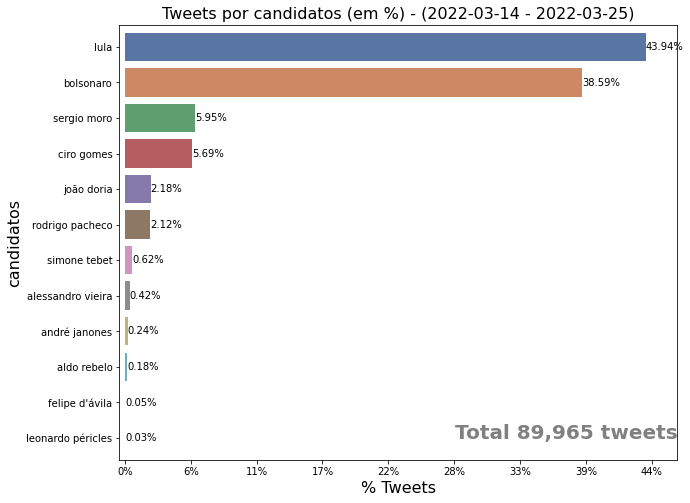

In [57]:
## Tweets por candidato (em %)

candidatos = dataframe \
   .groupby('query') \
   .agg(F.expr('count(distinct twitter_id)').alias('qtde')) \
   .sort(F.col('qtde').desc()).select('query').rdd.flatMap(lambda x: x).collect()
   
tweets = dataframe \
   .groupby('query') \
   .agg(F.expr('count(distinct twitter_id)').alias('qtde')) \
   .sort(F.col('qtde').desc()).select('qtde').rdd.flatMap(lambda x: x).collect()

min_date = dataframe.agg({'created_at_tz': 'min'}).rdd.flatMap(lambda x: x).collect()[0]

max_date = dataframe.agg({'created_at_tz': 'max'}).rdd.flatMap(lambda x: x).collect()[0]

chart_tweets(
    x = candidatos,
    y = tweets,
    params = {
        "x": "query",
        "y": "qtde",
        "annotation_w":3e4,
        "annotation_h":8,
        "x_title": "% Tweets",
        "y_title": "candidatos",
        "title":f"Tweets por candidatos (em %) - ({min_date} - {max_date})",
        "tweet_totals":True,
        "tweet_totals_title":"tweets"  
    }    
)

/tmp/ipykernel_55679/685794584.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


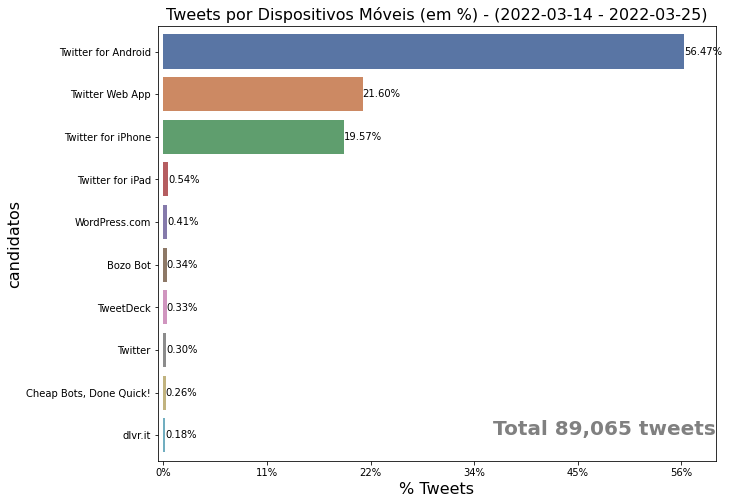

In [58]:
## Tweets por dispositivos (em %)

tweet_source = dataframe.groupby('source').agg( 
    F.count(F.col('twitter_id')).alias('qtde') 
).sort(
    F.col('qtde').desc()
).limit(10).select('source').rdd.flatMap(lambda x: x).collect()

tweet_source_qtde = dataframe.groupby('source').agg( 
    F.count(F.col('twitter_id')).alias('qtde') 
).sort(
    F.col('qtde').desc()
).limit(10).select('qtde').rdd.flatMap(lambda x: x).collect()

chart_tweets(
    x = tweet_source,
    y = tweet_source_qtde,
    params = {
        "x": "query",
        "y": "qtde",
        "annotation_w":3e4,
        "annotation_h":8,
        "x_title": "% Tweets",
        "y_title": "candidatos",
        "title":f"Tweets por Dispositivos Móveis (em %) - ({min_date} - {max_date})",
        "tweet_totals":True,
        "tweet_totals_title":"tweets"  
    },
      
)

### HASHTAG VS MENTIONS

In [59]:
# nome dos candidatos
candidatos = dataframe \
   .groupby('query') \
   .agg(F.expr('count(distinct twitter_id)').alias('qtde')) \
   .sort(F.col('qtde').desc())

In [60]:
# hashtags
hashtag_map = F.udf( 
    lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*',x),
    ArrayType(StringType(), False)               
)

hashtag = dataframe.withColumn('hash', 
    hashtag_map(F.col('text'))
).select( 
    F.col('query'),F.explode(F.col('hash')).alias('hashtag')  
).groupby('query','hashtag').count().sort(F.col('count').desc()) \
.groupby('query').agg(F.sum('count').alias('hashtag_count')).sort(F.col('hashtag_count').desc())
# .rdd.flatMap(lambda x: x).collect()

In [61]:
mentions_map = F.udf( 
    lambda x: re.findall(r'\B@\w*[a-zA-Z]+\w*',x),
    ArrayType(StringType(), False)               
)

In [62]:
mentions = dataframe.withColumn('mentions', 
    mentions_map(F.col('text'))
).select( 
    F.col('query'),F.explode(F.col('mentions')).alias('mentions_mark')  
).groupby('query','mentions_mark').count().sort(F.col('count').desc()) \
.groupby('query').agg(F.sum('count').alias('mentions_count')).sort(F.col('mentions_count').desc())

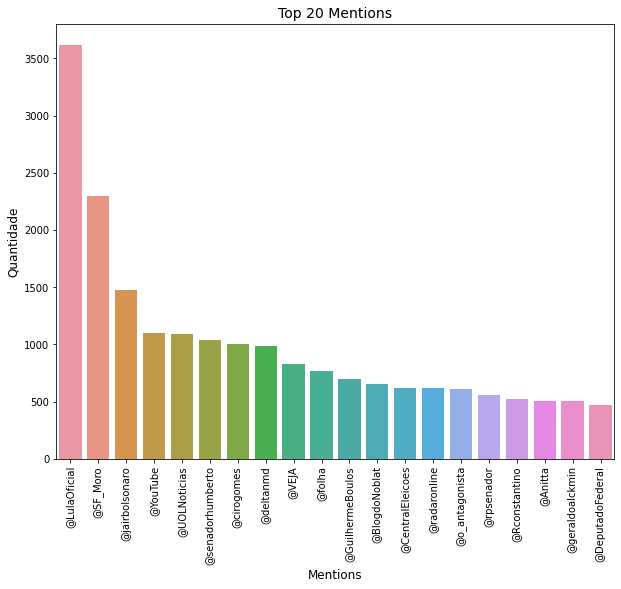

In [63]:
# TOP 10 MENTIONS

# DATAFRAME
df_mentions_stats = dataframe.withColumn('mentions', 
    mentions_map(F.col('text'))
).select( 
    F.col('query'),F.explode(F.col('mentions')).alias('mentions_mark')  
).groupby('mentions_mark').agg(
    F.count('mentions_mark').alias('mentions_count')
).sort(F.col('mentions_count').desc()).toPandas()

# CHART
plt.rcParams['figure.figsize'] = [10, 8]
ax = sns.barplot(x = 'mentions_mark', y = 'mentions_count', data=df_mentions_stats[0:20])
ax.set_ylabel('Quantidade',size=12)
ax.set_xlabel('Mentions',size=12)
ax.set_title('Top 20 Mentions', size=14)
ax.tick_params(axis='x', rotation=90)
plt.show()

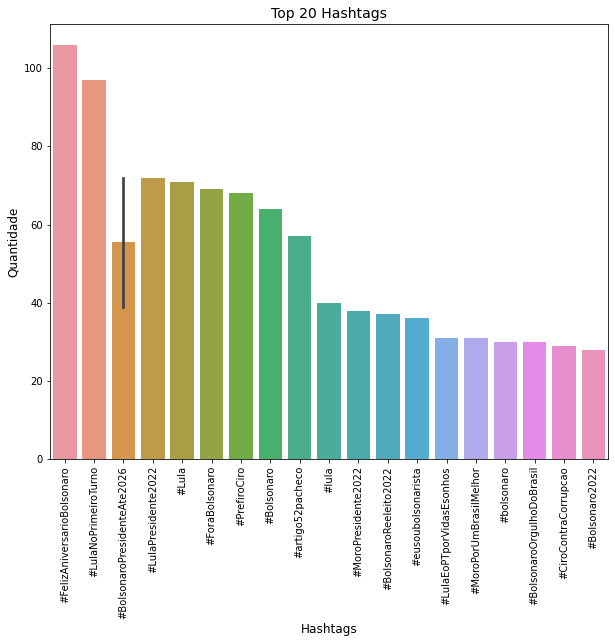

In [64]:
# TOP 10 HASHTAGS

# DATAFRAME
df_hashtag_stats = dataframe.withColumn('hash', 
    hashtag_map(F.col('text'))
).select( 
    F.col('query'),F.explode(F.col('hash')).alias('hashtag')  
).groupby('query','hashtag').agg(
    F.count('hashtag').alias('hashtag_count')
).sort(F.col('hashtag_count').desc()).toPandas()


# CHART
plt.rcParams['figure.figsize'] = [10, 8]
ax = sns.barplot(x = 'hashtag', y = 'hashtag_count', data=df_hashtag_stats[0:20])
ax.set_ylabel('Quantidade',size=12)
ax.set_xlabel('Hashtags',size=12)
ax.set_title('Top 20 Hashtags', size=14)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [65]:
df_hashtag_mentions = candidatos.join(
    hashtag,on='query',how='left'
).join(
    mentions,on='query',how='left'
).fillna(0).filter(F.col('hashtag_count')>0).filter(F.col('mentions_count')>0) \
.withColumnRenamed('query','candidatos') \
.withColumn('norm_qtde',F.log10('qtde')) \
.withColumn('norm_hashtag',F.log10('hashtag_count')) \
.withColumn('norm_mentions',F.log10('mentions_count')) \
.toPandas()

# 

In [66]:
df_hashtag_mentions

,candidatos,qtde,hashtag_count,mentions_count,norm_qtde,norm_hashtag,norm_mentions
0,lula,39532,1951,54561,4.596949,3.290257,4.736882
1,sergio moro,5349,405,6508,3.728273,2.607455,3.813448
2,simone tebet,556,14,649,2.745075,1.146128,2.812245
3,rodrigo pacheco,1905,172,2088,3.279895,2.235528,3.319730
4,aldo rebelo,164,2,325,2.214844,0.301030,2.511883
5,bolsonaro,34721,2076,42383,4.540592,3.317227,4.627192
6,ciro gomes,5117,405,6037,3.709015,2.607455,3.780821
7,joão doria,1960,166,2022,3.292256,2.220108,3.305781
8,alessandro vieira,375,11,380,2.574031,1.041393,2.579784
9,andré janones,218,10,143,2.338456,1.000000,2.155336


/tmp/ipykernel_55679/685794584.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_55679/685794584.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


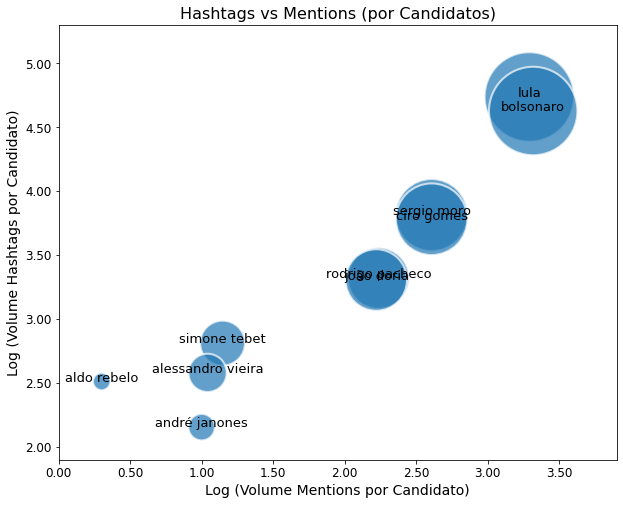

In [67]:
params = {
        'dataframe': df_hashtag_mentions,
        'x': 'norm_hashtag',
        'y': 'norm_mentions',
        'size': 'norm_qtde',
        'sizes': [300,8000],
        'axis_x_lim': [0, 3.9],
        'axis_y_lim': [1.9, 5.3],
        'axis_x_title': {
            'title':'Log (Volume Mentions por Candidato)',
            'size': 14
        },
        'axis_y_title': {
            'title':'Log (Volume Hashtags por Candidato)',
            'size': 14
        },
        'title':{
            'title':'Hashtags vs Mentions (por Candidatos)',
            'size': 16
        },
        'annotation_x': df_hashtag_mentions['norm_hashtag'],
        'annotation_y': df_hashtag_mentions['norm_mentions'],
        'annotation_size': df_hashtag_mentions['candidatos']
    }

bubble_chart_analysis(params)

### RETWEET VS LIKE

In [68]:
df_retweets_like = dataframe \
   .groupby('query') \
   .agg(
       F.expr('count(distinct twitter_id)').alias('qtde'),
       F.sum('retweet_count').alias('retweet_qtde'),
       F.sum('like_count').alias('like_qtde')
    ) \
   .sort(F.col('retweet_qtde').desc()) \
   .withColumnRenamed('query','candidatos') \
   .withColumn('norm_qtde',F.log10('qtde')) \
   .withColumn('norm_retweet',F.log10('retweet_qtde')) \
   .withColumn('norm_like',F.log10('like_qtde')) \
   .toPandas()

In [69]:
df_retweets_like

,candidatos,qtde,retweet_qtde,like_qtde,norm_qtde,norm_retweet,norm_like
0,bolsonaro,34721,757349,17486,4.540592,5.879296,4.242690
1,lula,39532,480991,18078,4.596949,5.682137,4.257150
2,sergio moro,5349,70401,7025,3.728273,4.847579,3.846646
3,joão doria,1960,48154,4853,3.292256,4.682632,3.686010
4,ciro gomes,5117,34332,6558,3.709015,4.535699,3.816771
5,rodrigo pacheco,1905,26434,1746,3.279895,4.422163,3.242044
6,simone tebet,556,5923,1884,2.745075,3.772542,3.275081
7,alessandro vieira,375,1795,1895,2.574031,3.254064,3.277609
8,andré janones,218,1491,606,2.338456,3.173478,2.782473
9,aldo rebelo,164,547,998,2.214844,2.737987,2.999131


/tmp/ipykernel_55679/685794584.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_55679/685794584.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


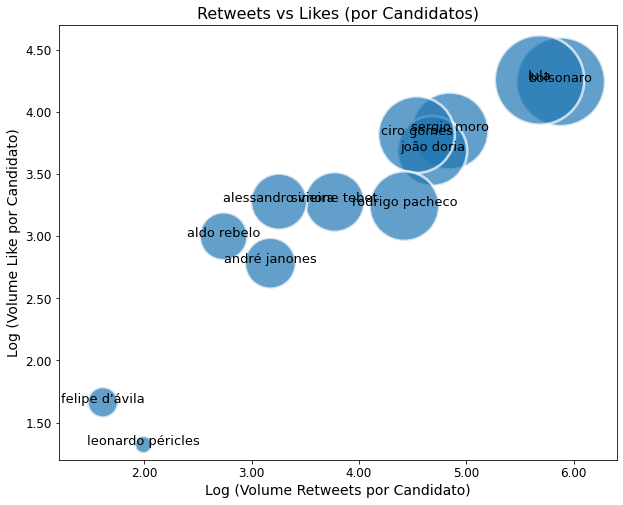

In [70]:
params = {
        'dataframe': df_retweets_like,
        'x': 'norm_retweet',
        'y': 'norm_like',
        'size': 'norm_qtde',
        'sizes': [300,8000],
        'axis_x_lim': [1.2, 6.4],
        'axis_y_lim': [1.2, 4.7],
        'axis_x_title': {
            'title':'Log (Volume Retweets por Candidato)',
            'size': 14
        },
        'axis_y_title': {
            'title':'Log (Volume Like por Candidato)',
            'size': 14
        },
        'title':{
            'title':'Retweets vs Likes (por Candidatos)',
            'size': 16
        },
        'annotation_x': df_retweets_like['norm_retweet'],
        'annotation_y': df_retweets_like['norm_like'],
        'annotation_size': df_retweets_like['candidatos']
    }

bubble_chart_analysis(params)

## ANALISE TOPICOS LULA VS BOLSONARO

### LULA

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from time import time

In [72]:
df_lula = dataframe.filter(
    F.col('query')=='lula'
).select(F.col('query'),F.col('twitter_id'),F.col('text'),F.col('text_clean'),F.col('like_count'),F.col('retweet_count')).toPandas()

In [73]:
df_lula

,query,twitter_id,text,text_clean,like_count,retweet_count
0,lula,1505862799431450629,RT @Fernand66938602: @GloboNews @gcamarotti “A...,a profissao honesta politico sabe pq todo ano ...,0,0
1,lula,1507055408665530375,"@pauloap Aah Moro tá fraco,coloca o LULA",aah moro ta fraco coloca lula,0,0
2,lula,1504202066369077248,@salimmattarbr É uma aberração um ministro seg...,aberracao ministro segurar processo privatizac...,0,0
3,lula,1503749776977842180,"""@UOLNoticias Abram a matéria pra descobrir o ...",abram materia pra descobrir quao sordido jorna...,0,0
4,lula,1505980437713272832,RT @edumilsonpapo10: Abriu mão de disputar o g...,abriu mao disputar governo paulo porque cadela...,0,2
...,...,...,...,...,...,...
39527,lula,1506652983685222412,RT @winniebueno: Vou votar no Lula já no prime...,vou votar lula primeiro turno acabar logo vez ...,0,72
39528,lula,1504616964584583170,"@amaria_del Eu não vou votar em Valdemar, agor...",vou votar valdemar agora deu vai votando fulan...,0,0
39529,lula,1503700867379306499,"O Waack dizer isso não é nenhum problema, eu n...",waack dizer nenhum problema nunca esperei nada...,1,0
39530,lula,1504060937787088909,RT @NunesJAp: O Whatsapp suspendeu várias cont...,whatsapp suspendeu varias contas pt restringiu...,0,351


In [74]:
# LULA TWEETS
lula_tweets = dataframe.filter(
    F.col('query')=='lula'
).select('text_clean').rdd.flatMap(lambda x: x).collect()

In [75]:
# LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
tf = tf_vectorizer.fit_transform(lula_tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
t2 = time()
lda = LatentDirichletAllocation(
    n_components = 5, 
    random_state=0,
    n_jobs=-1,
    verbose=1
).fit(tf)
print("done in %0.3fs." % (time() - t2))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
done in 16.553s.


In [76]:
# RELACIONANDO TWEETS REFERENTE A LULA COM OS TOPICOS IDENTIFICADOS
df_topics_lula = dataset_join_lda_topics(lda, tf, df_lula, lula_tweets)
df_topics_lula

,query,twitter_id,text,text_clean,like_count,retweet_count,docnames,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic,text_topic
0,lula,1505862799431450629,RT @Fernand66938602: @GloboNews @gcamarotti “A...,a profissao honesta politico sabe pq todo ano ...,0,0,Doc0,0.49,0.02,0.02,0.44,0.02,1,lula vai presidente vc pra
1,lula,1507055408665530375,"@pauloap Aah Moro tá fraco,coloca o LULA",aah moro ta fraco coloca lula,0,0,Doc1,0.03,0.03,0.86,0.03,0.03,3,lula bolsonaro pra vai votar
2,lula,1504202066369077248,@salimmattarbr É uma aberração um ministro seg...,aberracao ministro segurar processo privatizac...,0,0,Doc2,0.26,0.09,0.01,0.01,0.63,5,lula ex governo deltan presidente
3,lula,1503749776977842180,"""@UOLNoticias Abram a matéria pra descobrir o ...",abram materia pra descobrir quao sordido jorna...,0,0,Doc3,0.01,0.07,0.01,0.01,0.91,5,lula ex governo deltan presidente
4,lula,1505980437713272832,RT @edumilsonpapo10: Abriu mão de disputar o g...,abriu mao disputar governo paulo porque cadela...,0,2,Doc4,0.01,0.52,0.01,0.44,0.01,2,lula brasil governo vai bolsonaro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39527,lula,1506652983685222412,RT @winniebueno: Vou votar no Lula já no prime...,vou votar lula primeiro turno acabar logo vez ...,0,72,Doc39527,0.01,0.11,0.85,0.01,0.01,3,lula bolsonaro pra vai votar
39528,lula,1504616964584583170,"@amaria_del Eu não vou votar em Valdemar, agor...",vou votar valdemar agora deu vai votando fulan...,0,0,Doc39528,0.01,0.01,0.60,0.28,0.10,3,lula bolsonaro pra vai votar
39529,lula,1503700867379306499,"O Waack dizer isso não é nenhum problema, eu n...",waack dizer nenhum problema nunca esperei nada...,1,0,Doc39529,0.29,0.01,0.33,0.01,0.36,5,lula ex governo deltan presidente
39530,lula,1504060937787088909,RT @NunesJAp: O Whatsapp suspendeu várias cont...,whatsapp suspendeu varias contas pt restringiu...,0,351,Doc39530,0.01,0.48,0.01,0.14,0.35,2,lula brasil governo vai bolsonaro


In [77]:
df_topics_lula_consolidado = df_topics_lula.groupby(
    'text_topic'
).agg({
    'twitter_id':'nunique',
    'like_count':'sum',
    'retweet_count': 'sum',
}).reset_index()

df_topics_lula_consolidado['retweet_norm'] = df_topics_lula_consolidado['retweet_count'].apply(lambda x: np.log(x) )
df_topics_lula_consolidado['like_norm'] = df_topics_lula_consolidado['like_count'].apply(lambda x: np.log(x) )
df_topics_lula_consolidado['qtde_tweets_id'] = df_topics_lula_consolidado['twitter_id'].apply(lambda x: np.log(x) )
df_topics_lula_consolidado

,text_topic,twitter_id,like_count,retweet_count,retweet_norm,like_norm,qtde_tweets_id
0,lula bolsonaro pra vai votar,9988,3773,83864,11.336952,8.235626,9.209140
1,lula brasil governo vai bolsonaro,6827,2957,120532,11.699671,7.991931,8.828641
2,lula ex governo deltan presidente,6789,3729,143519,11.874223,8.223895,8.823059
3,lula ladrao alckmin ser pt,6862,3387,68212,11.130376,8.127700,8.833754
4,lula vai presidente vc pra,9066,4232,64864,11.080048,8.350430,9.112286


/tmp/ipykernel_55679/685794584.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_55679/685794584.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


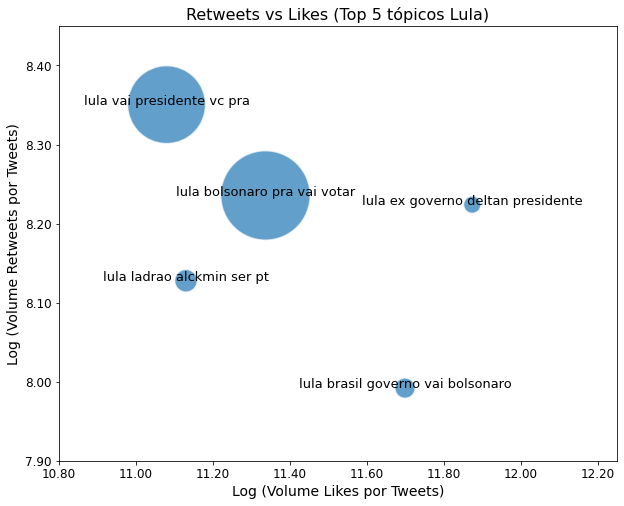

In [78]:
params = {
        'dataframe': df_topics_lula_consolidado,
        'x': 'retweet_norm',
        'y': 'like_norm',
        'size': 'qtde_tweets_id',
        'sizes': [300,8000],
        'axis_x_lim': [10.8, 12.25],
        'axis_y_lim': [7.9, 8.45],
        'axis_x_title': {
            'title':'Log (Volume Likes por Tweets)',
            'size': 14
        },
        'axis_y_title': {
            'title':'Log (Volume Retweets por Tweets)',
            'size': 14
        },
        'title':{
            'title':'Retweets vs Likes (Top 5 tópicos Lula)',
            'size': 16
        },
        'annotation_x': df_topics_lula_consolidado['retweet_norm'],
        'annotation_y': df_topics_lula_consolidado['like_norm'],
        'annotation_size': df_topics_lula_consolidado['text_topic']
    }

bubble_chart_analysis(params)

### BOLSONARO

In [79]:
df_bolsonaro = dataframe.filter(
    F.col('query')=='bolsonaro'
).select(F.col('query'),F.col('twitter_id'),F.col('text'),F.col('text_clean'),F.col('like_count'),F.col('retweet_count')).toPandas()
df_bolsonaro

,query,twitter_id,text,text_clean,like_count,retweet_count
0,bolsonaro,1503700925155876879,“a gasolina mais barata é a nossa” homi vai to...,a gasolina barata nossa homi vai tomar cu bols...,0,0
1,bolsonaro,1507381789802831896,@21ptm abafa o som bota na orelha quase liga p...,abafa som bota orelha quase liga pra pessoa of...,0,0
2,bolsonaro,1504974409907544067,@GirafaMulambaBR Isso é o que mais me aborrece...,aborrece sempre arrumam mimimi bolsonaro poder...,1,0
3,bolsonaro,1507036463506075653,"""@AntonyJojohn """"Abro aspas, fecho aspas""""...k...",abro aspas fecho aspas bolsonaro sabe aspas mano,0,0
4,bolsonaro,1506396492042575874,RT @RubensOtoni: 🔴ABSURDO: Autoridades pública...,absurdo autoridades publicas proferiram discur...,0,16
...,...,...,...,...,...,...
34716,bolsonaro,1504979620017356804,RT @viniciusduarte: Se o Xandão tivesse feito ...,xandao feito bloqueio telegram ontem tarde liv...,0,5
34717,bolsonaro,1506305672262168589,"@Haddad_Fernando Xiiiiiii, que é vc pra falar ...",xi vc pra falar bolsonaro apoiadores corrupcao,0,0
34718,bolsonaro,1506302527003926539,@xicosa @dainezi @JoelPinheiro85 Xico pau no c...,xico pau cu brasileiros idiotas esquerda imora...,0,0
34719,bolsonaro,1503799055817887751,"@AgendaDoJair yvone bolsonaro mandou o papo, v...",yvone bolsonaro mandou papo vaza brasil vai pr...,0,0


In [80]:
# BOLSONARO TWEETS
bolsonaro_tweets = dataframe.filter(
    F.col('query')=='bolsonaro'
).select('text_clean').rdd.flatMap(lambda x: x).collect()

In [81]:
# LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
tf = tf_vectorizer.fit_transform(bolsonaro_tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
t2 = time()
lda = LatentDirichletAllocation(
    n_components = 5, 
    random_state=0,
    n_jobs=-1,
    verbose=1
).fit(tf)
print("done in %0.3fs." % (time() - t2))

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
done in 14.096s.


In [82]:
# RELACIONANDO TWEETS REFERENTE A LULA COM OS TOPICOS IDENTIFICADOS
df_topics_bolsonaro = dataset_join_lda_topics(lda, tf, df_bolsonaro, bolsonaro_tweets)
df_topics_bolsonaro

,query,twitter_id,text,text_clean,like_count,retweet_count,docnames,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic,text_topic
0,bolsonaro,1503700925155876879,“a gasolina mais barata é a nossa” homi vai to...,a gasolina barata nossa homi vai tomar cu bols...,0,0,Doc0,0.02,0.91,0.02,0.02,0.02,2,bolsonaro vai pra ta cara
1,bolsonaro,1507381789802831896,@21ptm abafa o som bota na orelha quase liga p...,abafa som bota orelha quase liga pra pessoa of...,0,0,Doc1,0.69,0.02,0.02,0.02,0.26,1,bolsonaro pra brasil lula povo
2,bolsonaro,1504974409907544067,@GirafaMulambaBR Isso é o que mais me aborrece...,aborrece sempre arrumam mimimi bolsonaro poder...,1,0,Doc2,0.65,0.01,0.01,0.01,0.33,1,bolsonaro pra brasil lula povo
3,bolsonaro,1507036463506075653,"""@AntonyJojohn """"Abro aspas, fecho aspas""""...k...",abro aspas fecho aspas bolsonaro sabe aspas mano,0,0,Doc3,0.20,0.72,0.03,0.03,0.03,2,bolsonaro vai pra ta cara
4,bolsonaro,1506396492042575874,RT @RubensOtoni: 🔴ABSURDO: Autoridades pública...,absurdo autoridades publicas proferiram discur...,0,16,Doc4,0.02,0.02,0.02,0.46,0.49,5,bolsonaro presidente jair governo brasil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34716,bolsonaro,1504979620017356804,RT @viniciusduarte: Se o Xandão tivesse feito ...,xandao feito bloqueio telegram ontem tarde liv...,0,5,Doc34716,0.02,0.02,0.92,0.02,0.02,3,bolsonaro presidente ser agora governo
34717,bolsonaro,1506305672262168589,"@Haddad_Fernando Xiiiiiii, que é vc pra falar ...",xi vc pra falar bolsonaro apoiadores corrupcao,0,0,Doc34717,0.80,0.03,0.03,0.13,0.03,1,bolsonaro pra brasil lula povo
34718,bolsonaro,1506302527003926539,@xicosa @dainezi @JoelPinheiro85 Xico pau no c...,xico pau cu brasileiros idiotas esquerda imora...,0,0,Doc34718,0.70,0.26,0.01,0.01,0.01,1,bolsonaro pra brasil lula povo
34719,bolsonaro,1503799055817887751,"@AgendaDoJair yvone bolsonaro mandou o papo, v...",yvone bolsonaro mandou papo vaza brasil vai pr...,0,0,Doc34719,0.78,0.02,0.02,0.02,0.16,1,bolsonaro pra brasil lula povo


In [83]:
df_topics_bolsonaro_consolidado = df_topics_bolsonaro.groupby(
    'text_topic'
).agg({
    'twitter_id':'nunique',
    'like_count':'sum',
    'retweet_count': 'sum',
}).reset_index()

df_topics_bolsonaro_consolidado['retweet_norm'] = df_topics_bolsonaro_consolidado['retweet_count'].apply(lambda x: np.log(x) )
df_topics_bolsonaro_consolidado['like_norm'] = df_topics_bolsonaro_consolidado['like_count'].apply(lambda x: np.log(x) )
df_topics_bolsonaro_consolidado['qtde_tweets_id'] = df_topics_bolsonaro_consolidado['twitter_id'].apply(lambda x: np.log(x) )
df_topics_bolsonaro_consolidado

,text_topic,twitter_id,like_count,retweet_count,retweet_norm,like_norm,qtde_tweets_id
0,bolsonaro governo ministro corrupcao educacao,5619,3965,113068,11.635745,8.285261,8.633909
1,bolsonaro pra brasil lula povo,8908,4028,140270,11.851324,8.301025,9.094705
2,bolsonaro presidente jair governo brasil,6595,3594,222625,12.313244,8.187021,8.794067
3,bolsonaro presidente ser agora governo,5737,3125,152812,11.936964,8.047190,8.654692
4,bolsonaro vai pra ta cara,7862,2774,128574,11.764260,7.928046,8.969796


/tmp/ipykernel_55679/685794584.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), size = 12)
/tmp/ipykernel_55679/685794584.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/tmp/ipykernel_55679/685794584.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


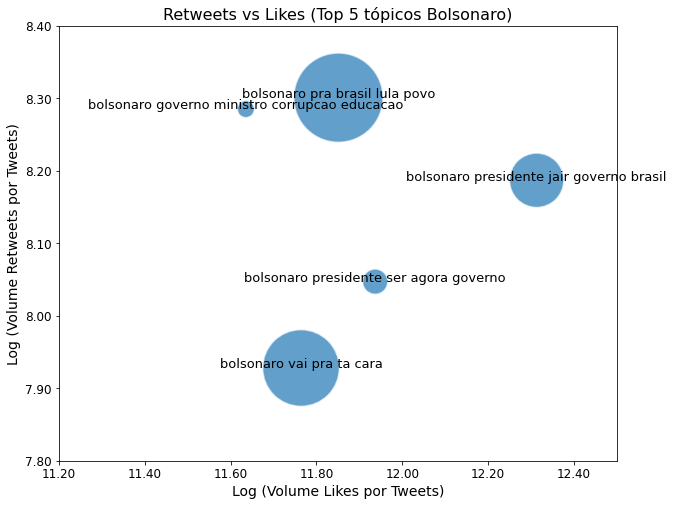

In [84]:

params = {
        'dataframe': df_topics_bolsonaro_consolidado,
        'x': 'retweet_norm',
        'y': 'like_norm',
        'size': 'qtde_tweets_id',
        'sizes': [300,8000],
        'axis_x_lim': [11.2, 12.5],
        'axis_y_lim': [7.8, 8.4],
        'axis_x_title': {
            'title':'Log (Volume Likes por Tweets)',
            'size': 14
        },
        'axis_y_title': {
            'title':'Log (Volume Retweets por Tweets)',
            'size': 14
        },
        'title':{
            'title':'Retweets vs Likes (Top 5 tópicos Bolsonaro)',
            'size': 16
        },
        'annotation_x': df_topics_bolsonaro_consolidado['retweet_norm'],
        'annotation_y': df_topics_bolsonaro_consolidado['like_norm'],
        'annotation_size': df_topics_bolsonaro_consolidado['text_topic']
    }

bubble_chart_analysis(params)